In the first notebook, we looked at some basic functions of our custom `RxnTools` package to extract all transformed atoms and bonds from a given, fully-atom mapped reaction. Subsequently, in the second notebook, we looked into some nuances with extracting substructures and templates around these transformed atoms. Here, we will implement these nuances into accurately extracting reaction environments around atom-mapped substrates in order to generate reaction rules/ templates both with and without stereochemistry. We begin by considering only reactions that take in a single substrate and produce a single product. All atom-mapped reactions and substrates are taken from Esther Heid's publication of the EnzymeMap database (https://pubs.rsc.org/en/content/articlehtml/2023/sc/d3sc02048g).

In [191]:
import json
from rxntools import reaction, utils, draw
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Draw, rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from IPython.display import display, SVG
from PIL import Image
from copy import deepcopy
import io

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

#### Example 1: Alcohol dehydrogenase oxidizing NAD(+)/NADH

Let's revisit the oxidation of ethanol to ethanal with an alcohol dehydrogenase that uses the NAD(+)/ NADH cofactor pair.

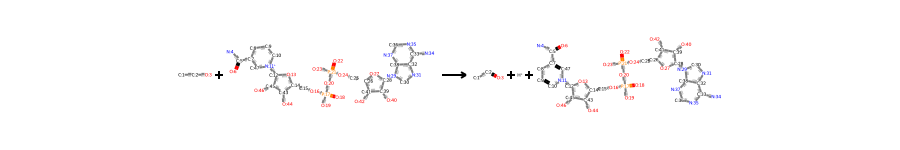

In [192]:
atom_mapped_ethanol_AdH_rxn_smarts = '[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][cH:10][n+:11]([C@@H:12]2[O:13][C@H:14]([CH2:15][O:16][P:17](=[O:18])([OH:19])[O:20][P:21](=[O:22])([OH:23])[O:24][CH2:25][C@H:26]3[O:27][C@@H:28]([n:29]4[cH:30][n:31][c:32]5[c:33]([NH2:34])[n:35][cH:36][n:37][c:38]45)[C@H:39]([OH:40])[C@@H:41]3[OH:42])[C@@H:43]([OH:44])[C@H:45]2[OH:46])[cH:47]1>>[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[C:7]1=[CH:47][N:11]([C@@H:12]2[O:13][C@H:14]([CH2:15][O:16][P:17](=[O:18])([OH:19])[O:20][P:21](=[O:22])([OH:23])[O:24][CH2:25][C@H:26]3[O:27][C@@H:28]([n:29]4[cH:30][n:31][c:32]5[c:33]([NH2:34])[n:35][cH:36][n:37][c:38]45)[C@H:39]([OH:40])[C@@H:41]3[OH:42])[C@@H:43]([OH:44])[C@H:45]2[OH:46])[CH:10]=[CH:9][CH2:8]1'
AllChem.ReactionFromSmarts(atom_mapped_ethanol_AdH_rxn_smarts)

Now, let's extract the transformed atoms in ethanol. For this, we ignore cofactors by setting the `include_cofactors` argument within the function `get_all_changed_atoms` to `include_cofactors = False`. We set `consider_stereo = True` so that we can also factor in stereochemistry when identifying which participating species in a reaction is a cofactor as opposed to a substrate or a product. Finally, we load in our list of cofactors to pass into the `cofactors list` argument of this function.

In [193]:
with open('../data/raw/cofactors.json') as f:
    cofactors_dict = json.load(f)
cofactors_list = [cofactors_dict[key] for key in cofactors_dict.keys()]

In [194]:
mapped_rxn = reaction.mapped_reaction(rxn_smarts = atom_mapped_ethanol_AdH_rxn_smarts)
changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(include_cofactors = False, 
                                                                             consider_stereo = True,
                                                                             cofactors_list = cofactors_list)

As expected, since ethanol (`[CH3:1][CH2:2][OH:3]`) is transformed to ethanal (`CH3:1][CH:2]=[O:3]`), the C2-O3 bond gets oxidized to C2=O3 so the changed atoms correspond to those with atom indices 2 and 3 in the atomic map of ethanol.

In [195]:
changed_atoms

{2, 3}

Now, to get reaction templates for ethanol, we pass in the atom-mapped SMARTS string for ethanol as well as the indices of the changed atoms into the static method `get_template_around_rxn_site` within the `mapped_reaction` class. Since ethanol is not a chiral molecule, we set the `include_stereo` argument to `False`.

In [196]:
template = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = '[CH3:1][CH2:2][OH:3]',
                                                   reactive_atom_indices = list(changed_atoms),
                                                   radius = 1,
                                                   include_stereo = False)

In [197]:
template

'[C&H3:1][C&H2:2][O&H1:3]'

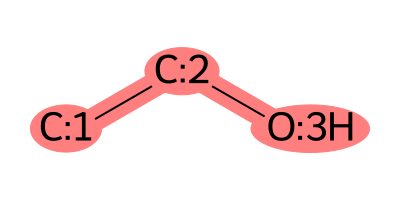

In [198]:
draw.highlight_substructures_in_notebook(substrate_smarts = "[CH3:1][CH2:2][OH:3]",
                                          substructure_smarts = template)

Since ethanol is such a small molecule, we've already encapsulated the whole molecule with a radius of 1 and increasing this radius to 2 simply returns the whole molecule again.

In [199]:
template = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = '[CH3:1][CH2:2][OH:3]',
                                                   reactive_atom_indices = list(changed_atoms),
                                                   radius = 2,
                                                   include_stereo = False)

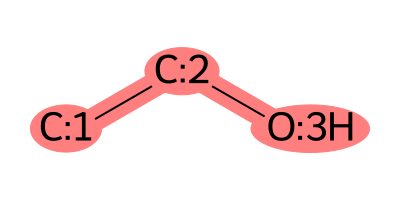

In [200]:
draw.highlight_substructures_in_notebook(substrate_smarts = "[CH3:1][CH2:2][OH:3]",
                                          substructure_smarts = template)

In [201]:
template

'[C&H3:1][C&H2:2][O&H1:3]'

Increasing the radius to 3 will not return any template and will only return an empty string. This is because, there are no more bonds and atoms left to encapsulate within ethanol:

In [202]:
template = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = '[CH3:1][CH2:2][OH:3]',
                                                   reactive_atom_indices = list(changed_atoms),
                                                   radius = 3,
                                                   include_stereo = False)

template

''

#### Example 2: Nitrilase reaction transforming mandelonitrile to benzaldehyde

Let's switch from an alcohol dehydrogenase reaction to a nitrilase reaction involving a larger substrate with some chiral carbon atoms present too.

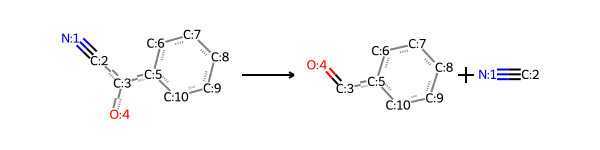

In [203]:
atom_mapped_nitrilase_rxn_smarts = '[N:1]#[C:2][C@H:3]([OH:4])[c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1>>[CH:3](=[O:4])[c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1.[N:1]#[CH:2]'
AllChem.ReactionFromSmarts(atom_mapped_nitrilase_rxn_smarts)

In [204]:
rxn = AllChem.ReactionFromSmarts("[C+0:1]=[C+0:2][C+0:3]=[C+0:4].[C+0:5]=[C+0:6]>>[*:1]1[*:2]=[*:3][*:4][*:6][*:5]1")

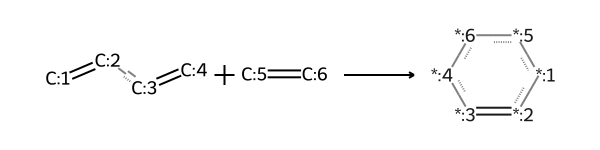

In [205]:
AllChem.ReactionFromSmarts("[#6:1]=[#6:2][#6:3]=[#6:4].[#6:5]=[#6:6]>>[*:1]1[*:2]=[*:3][*:4][*:6][*:5]1")

In [206]:
mapped_rxn = reaction.mapped_reaction(rxn_smarts = atom_mapped_nitrilase_rxn_smarts)

changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(include_cofactors = True,
                                                                             consider_stereo = True,
                                                                             cofactors_list = cofactors_list)

In [207]:
changed_atoms

{2, 3, 4}

In [208]:
mandelonitrile_atom_mapped_SMARTS = '[N:1]#[C:2][C@H:3]([OH:4])[c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1'

template_radius1_w_stereo = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                                           reactive_atom_indices = list(changed_atoms),
                                                           radius = 1,
                                                           include_stereo = True)

In this reaction, the C2-C3 bond is broken in order to release a nitrile while the atoms with indices 1, 2, 3, and 4 are transformed. Consequently, the resulting template generated at a radius of 1, `template_radius1` will consider all groups that exist 1 bond away from N1, C2, C3, and O4:

In [209]:
template_radius1_w_stereo

'[N:1]#[C:2][C@&H1:3]([O&H1:4])[c:5]'

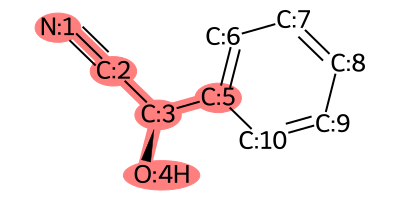

In [210]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                          substructure_smarts = template_radius1_w_stereo,
                                          consider_stereo = True)

At a radius of 2, a larger substructure of mandelonitrile will be encapsulated:

In [211]:
template_radius2_w_stereo = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                                           reactive_atom_indices = list(changed_atoms),
                                                           radius = 2,
                                                           include_stereo = True)

template_radius2_w_stereo

'[N:1]#[C:2][C@&H1:3]([O&H1:4])[c:5]([c&H1:6])[c&H1:10]'

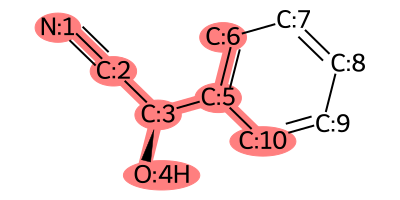

In [212]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                          substructure_smarts = template_radius2_w_stereo,
                                          consider_stereo = True)

At a radius of 3, we get an even larger substructure:

In [213]:
template_radius3_w_stereo = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                                           reactive_atom_indices = list(changed_atoms),
                                                           radius = 3,
                                                           include_stereo = True)

template_radius3_w_stereo

'[N:1]#[C:2][C@&H1:3]([O&H1:4])[c:5]([c&H1:6][c&H1:7])[c&H1:10][c&H1:9]'

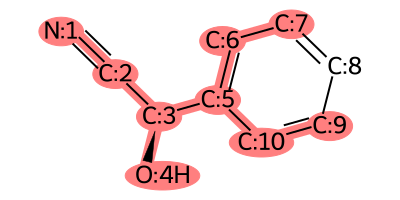

In [214]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                          substructure_smarts = template_radius3_w_stereo,
                                          consider_stereo = True)

Finally, at a radius of 4, the entire mandelonitrile molecule will be captured:

In [215]:
template_radius4_w_stereo = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                                           reactive_atom_indices = list(changed_atoms),
                                                           radius = 4,
                                                           include_stereo = True)

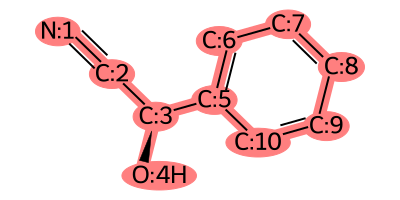

In [216]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                          substructure_smarts = template_radius4_w_stereo,
                                          consider_stereo = True)

In [217]:
template_radius4_w_stereo

'[N:1]#[C:2][C@&H1:3]([O&H1:4])[c:5]1[c&H1:6][c&H1:7][c&H1:8][c&H1:9][c&H1:10]1'

As a reminder, these templates have thus far been extracted with stereochemistry information, which is why when we print them out, we see the `@` operators to indicate chirality. We can also extract templates **without** any stereochemistry information by merely setting the `include_stereo` parameter within the method `.get_template_around_rxn_site` to `False`:

In [218]:
template_radius4_wo_stereo = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = mandelonitrile_atom_mapped_SMARTS,
                                                           reactive_atom_indices = list(changed_atoms),
                                                           radius = 4,
                                                           include_stereo = False)

template_radius4_wo_stereo

'[N:1]#[C:2][C&H1:3]([O&H1:4])[c:5]1[c&H1:6][c&H1:7][c&H1:8][c&H1:9][c&H1:10]1'